In [35]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, matthews_corrcoef, fowlkes_mallows_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Reading data from CSV file

In [2]:
data = np.genfromtxt('creditcard.csv', delimiter=',', skip_header=1, dtype=float)
fraud_data = data[data[:,30]==1]
real_data = data[data[:,30]==0]
#random_samples = np.random.choice(real_data.shape[0],real_data.shape[0]//10) #Undersampling step
#real_data = real_data[random_samples]
final_data = np.concatenate((real_data,fraud_data),axis=0)
final_data = final_data[:,1:31] #Extract columns we want
X_original = final_data[:,0:28]
y_original = final_data[:,29]
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.20)
print(X_train.shape)
test_fraud = y_train[y_train==1]
test_genuine = y_train[y_train==0]
print(test_fraud.shape)

(227845, 28)
(387,)


# Logistic Regression by Itself

<IPython.core.display.Javascript object>


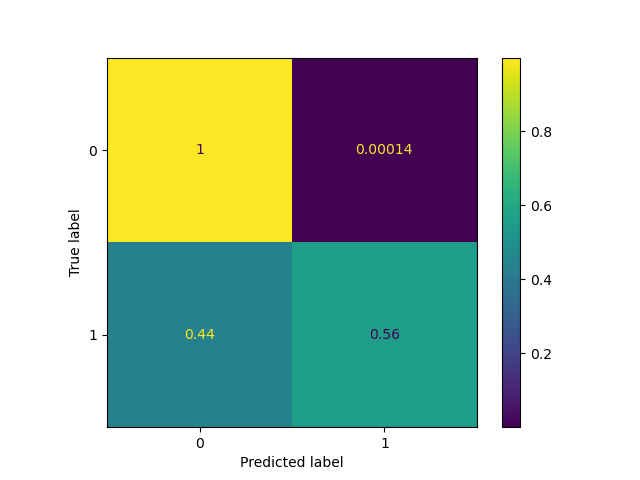

<IPython.core.display.Javascript object>


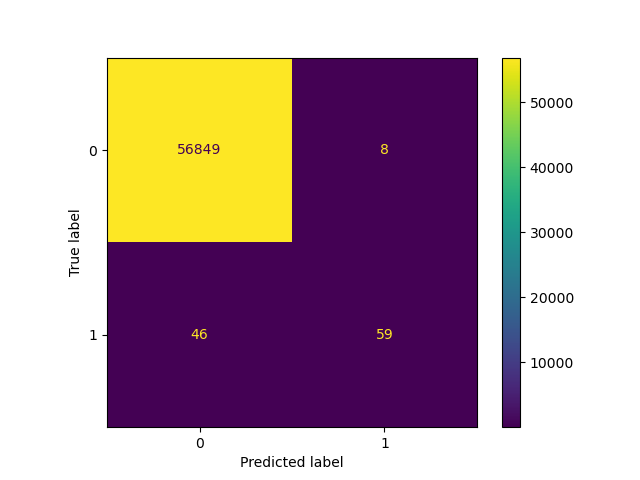

Specificity:  0.9998592961288848
Recall:  0.5619047619047619
Balanced Accuracy:  0.7808820290168234


In [67]:
log_reg = LogisticRegression(max_iter=1000).fit(X_train,y_train)
normal_results = log_reg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, normal_results).ravel()
cm = confusion_matrix(y_test,normal_results,normalize="true")
cm_2 = confusion_matrix(y_test,normal_results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp.plot()
disp_2.plot()
plt.show()
specificity = (tn / (tn+fp))
recall = (tp / (tp+fn))
balanced_acc = (balanced_accuracy_score(y_test, normal_results))
print('Specificity: ', specificity)
print('Recall: ', recall)
print('Balanced Accuracy: ', balanced_acc)

# SMOTE step

In [9]:
X_smote = []
y_smote = []
oversample = []
for i in range(1,21):
    oversample.append(SMOTE(sampling_strategy={0: test_genuine.shape[0], 1: test_fraud.shape[0]*i*10}))
    X_temp, y_temp = oversample[i-1].fit_resample(X_train, y_train)
    X_smote.append(X_temp)
    y_smote.append(y_temp)

In [10]:
log_reg_smote = []
smote_results = []
balanced_acc = []
specificity = []
recall = []
for i in range(20):
    log_reg_smote.append(LogisticRegression(max_iter=1000).fit(X_smote[i],y_smote[i]))
    smote_results.append(log_reg_smote[i].predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, smote_results[i]).ravel()
    specificity.append(tn / (tn+fp))
    recall.append(tp / (tp+fn))
    balanced_acc.append(balanced_accuracy_score(y_test, smote_results[i]))

<IPython.core.display.Javascript object>


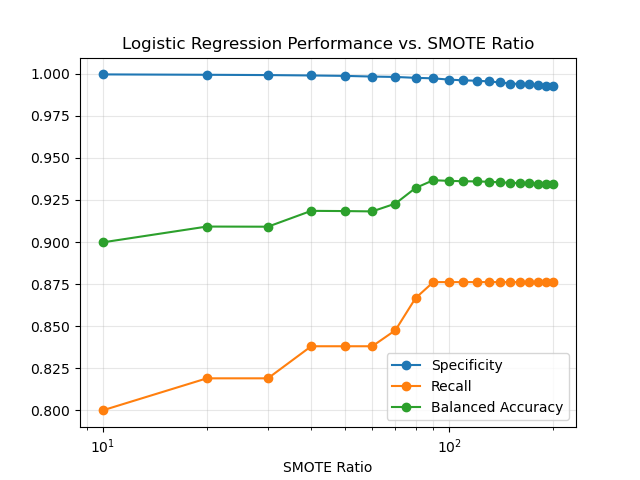

In [34]:
smote_ratios = list(range(10,210,10))
plt.plot(smote_ratios, specificity, '-o')
plt.plot(smote_ratios, recall, '-o')
plt.plot(smote_ratios, balanced_acc, '-o')
plt.xscale("log")
plt.xlabel("SMOTE Ratio")
plt.legend(['Specificity','Recall','Balanced Accuracy'])
plt.title('Logistic Regression Performance vs. SMOTE Ratio')
plt.grid(which='both', alpha=0.3)

# Undersampling

In [48]:
X_undersample = [X_train]
y_undersample = [y_train]
undersample = [RandomUnderSampler(sampling_strategy={0: int(test_genuine.shape[0]), 1: test_fraud.shape[0]})]
n = 1
for i in range(10,10002,50):
    undersample.append(RandomUnderSampler(sampling_strategy={0: int(test_genuine.shape[0]/i), 1: test_fraud.shape[0]}))
    X_temp, y_temp = undersample[n].fit_resample(X_train, y_train)
    X_undersample.append(X_temp)
    y_undersample.append(y_temp)
    n+=1
print(len(X_undersample))

201


In [49]:
log_reg_undersample = []
undersample_results = []
balanced_acc = []
specificity = []
recall = []
for i in range(201):
    log_reg_undersample.append(LogisticRegression(max_iter=1000).fit(X_undersample[i],y_undersample[i]))
    undersample_results.append(log_reg_undersample[i].predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, undersample_results[i]).ravel()
    specificity.append(tn / (tn+fp))
    recall.append(tp / (tp+fn))
    balanced_acc.append(balanced_accuracy_score(y_test, undersample_results[i]))

<IPython.core.display.Javascript object>


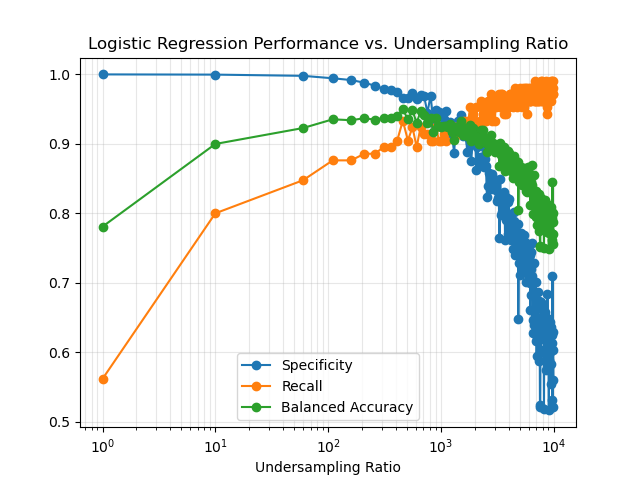

In [51]:
undersample_ratios = np.arange(10,10002,50)
undersample_ratios = np.insert(undersample_ratios, 0, 1., axis=0)
plt.plot(undersample_ratios, specificity, '-o')
plt.plot(undersample_ratios, recall, '-o')
plt.plot(undersample_ratios, balanced_acc, '-o')
plt.xscale("log")
plt.xlabel("Undersampling Ratio")
plt.legend(['Specificity','Recall','Balanced Accuracy'])
plt.title('Logistic Regression Performance vs. Undersampling Ratio')
plt.grid(which='both', alpha=0.3)

# Logistic Regression with Optimal SMOTE

<IPython.core.display.Javascript object>


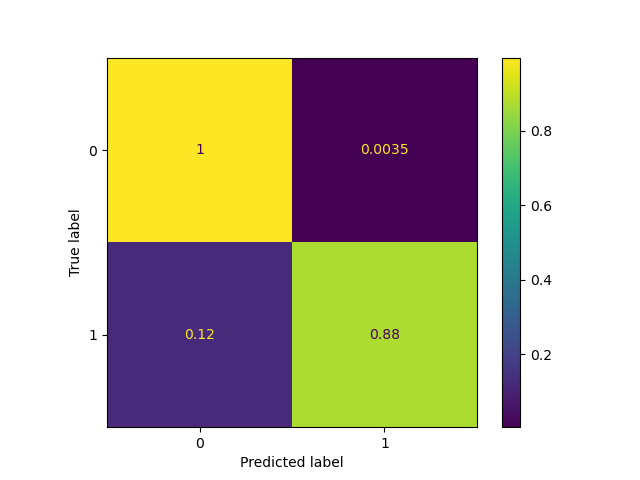

<IPython.core.display.Javascript object>


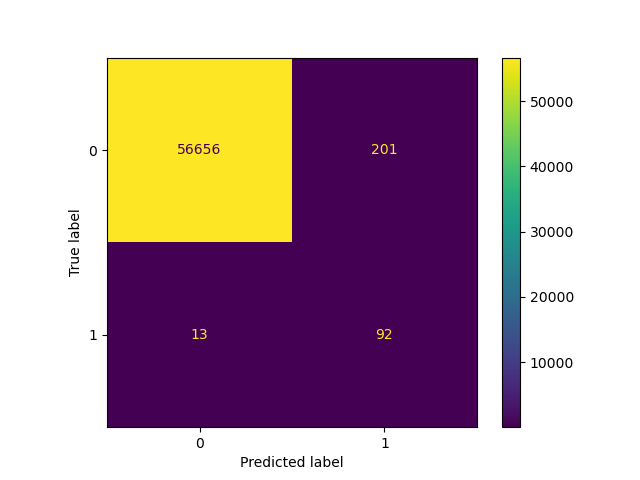

Specificity:  0.9964648152382293
Recall:  0.8761904761904762
Balanced Accuracy:  0.9363276457143528


In [65]:
# undersample_optimal = RandomUnderSampler(sampling_strategy={0: int(test_genuine.shape[0]/5), 1: test_fraud.shape[0]})
# X_optimal, y_optimal = undersample_optimal.fit_resample(X_train, y_train)
SMOTE_optimal = SMOTE(sampling_strategy={0: test_genuine.shape[0], 1: test_fraud.shape[0]*100})
X_optimal, y_optimal = SMOTE_optimal.fit_resample(X_train, y_train)
log_reg = LogisticRegression(max_iter=1000).fit(X_optimal,y_optimal)
optimal_results = log_reg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, optimal_results).ravel()
cm = confusion_matrix(y_test,optimal_results,normalize="true")
cm_2 = confusion_matrix(y_test,optimal_results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp.plot()
disp_2.plot()
plt.show()
specificity = (tn / (tn+fp))
recall = (tp / (tp+fn))
balanced_acc = (balanced_accuracy_score(y_test, optimal_results))
print('Specificity: ', specificity)
print('Recall: ', recall)
print('Balanced Accuracy: ', balanced_acc)

<IPython.core.display.Javascript object>


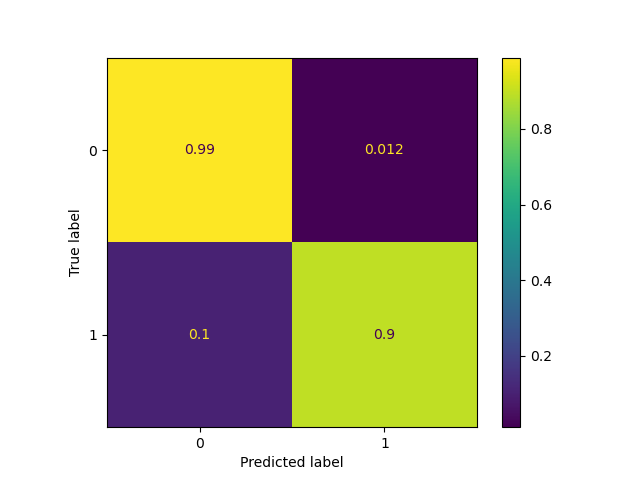

<IPython.core.display.Javascript object>


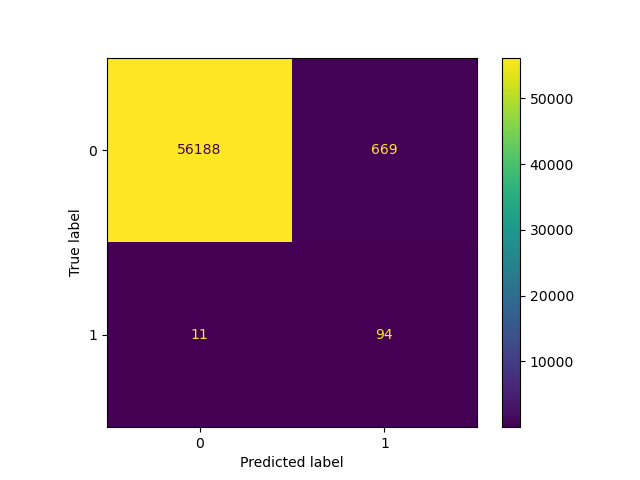

Specificity:  0.9882336387779869
Recall:  0.8952380952380953
Balanced Accuracy:  0.9417358670080411


In [62]:
undersample_optimal = RandomUnderSampler(sampling_strategy={0: int(test_genuine.shape[0]/200), 1: test_fraud.shape[0]})
X_optimal, y_optimal = undersample_optimal.fit_resample(X_train, y_train)
log_reg = LogisticRegression(max_iter=1000).fit(X_optimal,y_optimal)
optimal_results = log_reg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, optimal_results).ravel()
cm = confusion_matrix(y_test,optimal_results,normalize="true")
cm_2 = confusion_matrix(y_test,optimal_results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp.plot()
disp_2.plot()
plt.show()
specificity = (tn / (tn+fp))
recall = (tp / (tp+fn))
balanced_acc = (balanced_accuracy_score(y_test, optimal_results))
print('Specificity: ', specificity)
print('Recall: ', recall)
print('Balanced Accuracy: ', balanced_acc)

# Logistic Regression with Balanced Class Weights

<IPython.core.display.Javascript object>


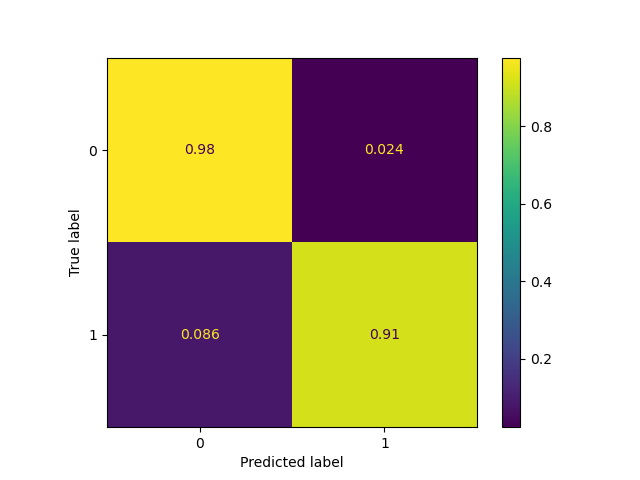

<IPython.core.display.Javascript object>


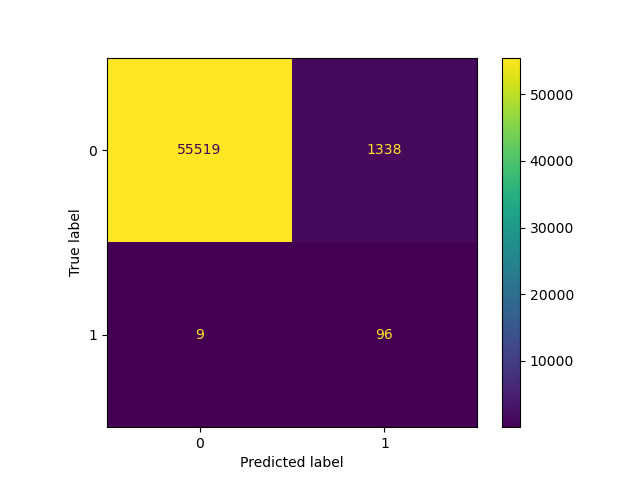

Specificity:  0.9764672775559737
Recall:  0.9142857142857143
Balanced Accuracy:  0.9453764959208439


In [55]:
log_reg = LogisticRegression(max_iter=1000,class_weight='balanced').fit(X_train,y_train)
weight_results = log_reg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, weight_results).ravel()
cm = confusion_matrix(y_test,weight_results,normalize="true")
cm_2 = confusion_matrix(y_test,weight_results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp.plot()
disp_2.plot()
plt.show()
specificity = (tn / (tn+fp))
recall = (tp / (tp+fn))
balanced_acc = (balanced_accuracy_score(y_test, weight_results))
print('Specificity: ', specificity)
print('Recall: ', recall)
print('Balanced Accuracy: ', balanced_acc)

# Balanced Class Weights with Optimal Undersampling

<IPython.core.display.Javascript object>


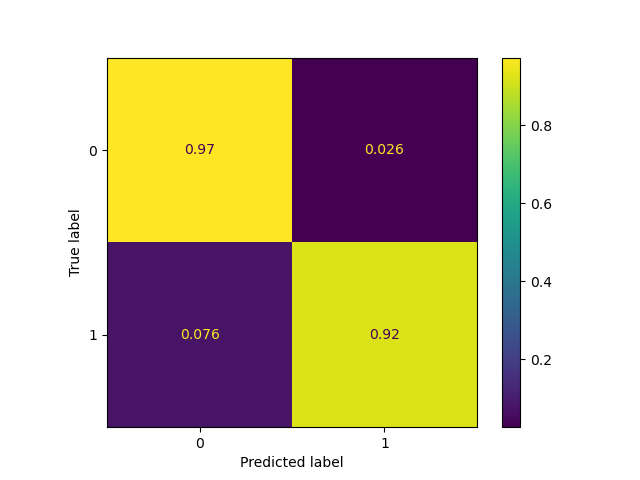

<IPython.core.display.Javascript object>


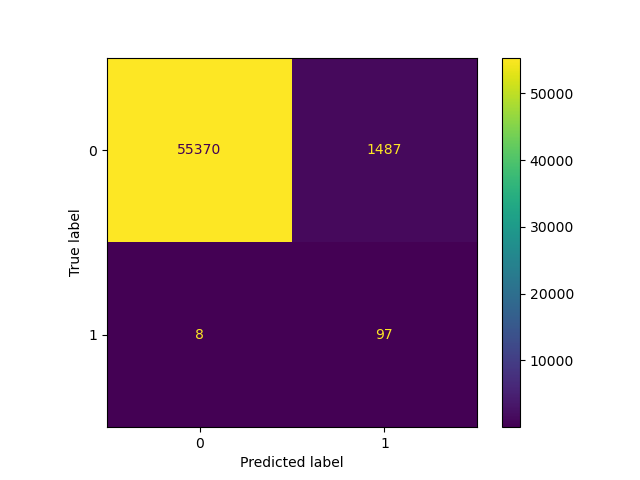

Specificity:  0.9738466679564521
Recall:  0.9238095238095239
Balanced Accuracy:  0.948828095882988


In [66]:
log_reg = LogisticRegression(max_iter=1000,class_weight='balanced').fit(X_optimal,y_optimal)
weight_results = log_reg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, weight_results).ravel()
cm = confusion_matrix(y_test,weight_results,normalize="true")
cm_2 = confusion_matrix(y_test,weight_results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp.plot()
disp_2.plot()
plt.show()
specificity = (tn / (tn+fp))
recall = (tp / (tp+fn))
balanced_acc = (balanced_accuracy_score(y_test, weight_results))
print('Specificity: ', specificity)
print('Recall: ', recall)
print('Balanced Accuracy: ', balanced_acc)